[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)

### based on Fig. 1 from Wojciech Grabowski and Hanna Pawlowska 2023 (Geophysical Research Letters 50(3)) 'Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem'

https://doi.org/10.1029/2022GL101917

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open-atmos-jupyter-utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import PySDM
print(PySDM.__file__)

/home/agnieszka/Github/PySDM/PySDM/__init__.py


In [23]:
import numpy as np
from matplotlib import pyplot
import matplotlib.ticker as ticker
from scipy.ndimage.filters import uniform_filter1d
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal
from PySDM.products import (
    ParcelDisplacement, AmbientTemperature, AmbientRelativeHumidity,
    ParticleSizeSpectrumPerVolume, ParticleVolumeVersusRadiusLogarithmSpectrum
)

from PySDM_examples.Grabowski_and_Pawlowska_2023 import Settings, Simulation

/tmp/ipykernel_20436/3461187329.py:4: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [4]:
#pristine
settings = Settings(
    dz = 1 * si.m,
    n_sd_per_mode = (25, 25),
    aerosol_modes_by_kappa = {
        1.28: Lognormal(norm_factor=125 / si.cm ** 3,m_mode=11 * si.nm,s_geom=1.2),
        1.280001: Lognormal(norm_factor=65 / si.cm ** 3,m_mode=60 * si.nm,s_geom=1.7)
    },
    vertical_velocity = 0.25 * si.m / si.s,
    initial_pressure = 900 * si.mbar,
    initial_temperature = 283 * si.K,
    initial_relative_humidity = .97,
    displacement = 1000 * si.m,
    formulae = Formulae(constants={'MAC': .3})
)

dry_radius_bin_edges = np.logspace(
    np.log10(4 * si.nm),
    np.log10(400 * si.nm),
    200, endpoint=False
)

simulation = Simulation(settings, products=(
    ParcelDisplacement(
        name='z'),
    AmbientRelativeHumidity(
        name='S_max', unit='%', var='RH'),
    AmbientTemperature(
        name='T'),
    ParticleSizeSpectrumPerVolume(
        name='dry:dN/dR', radius_bins_edges=dry_radius_bin_edges, dry=True),
    ParticleVolumeVersusRadiusLogarithmSpectrum(
        name='dry:dV/dlnR', radius_bins_edges=dry_radius_bin_edges, dry=True),
))
output_PRI = simulation.run()

In [5]:
#polluted
settings = Settings(
    dz = 1 * si.m,
    n_sd_per_mode = (25, 25),
    aerosol_modes_by_kappa = {
        1.28: Lognormal(
            norm_factor=160 / si.cm ** 3,
            m_mode=29 * si.nm,
            s_geom=1.36
        ),
        1.280001: Lognormal(
            norm_factor=380 / si.cm ** 3,
            m_mode=71 * si.nm,
            s_geom=1.57
        )
    },
    vertical_velocity = 0.25 * si.m / si.s,
    initial_pressure = 900 * si.mbar,
    initial_temperature = 283 * si.K,
    initial_relative_humidity = .97,
    displacement = 1000 * si.m,
    formulae = Formulae(constants={'MAC': .3})
)

dry_radius_bin_edges = np.logspace(
    np.log10(4 * si.nm),
    np.log10(400 * si.nm),
    200, endpoint=False
)

simulation = Simulation(settings, products=(
    ParcelDisplacement(
        name='z'),
    AmbientRelativeHumidity(
        name='S_max', unit='%', var='RH'),
    AmbientTemperature(
        name='T'),
    ParticleSizeSpectrumPerVolume(
        name='dry:dN/dR', radius_bins_edges=dry_radius_bin_edges, dry=True),
    ParticleVolumeVersusRadiusLogarithmSpectrum(
        name='dry:dV/dlnR', radius_bins_edges=dry_radius_bin_edges, dry=True),
))
output_POL = simulation.run()

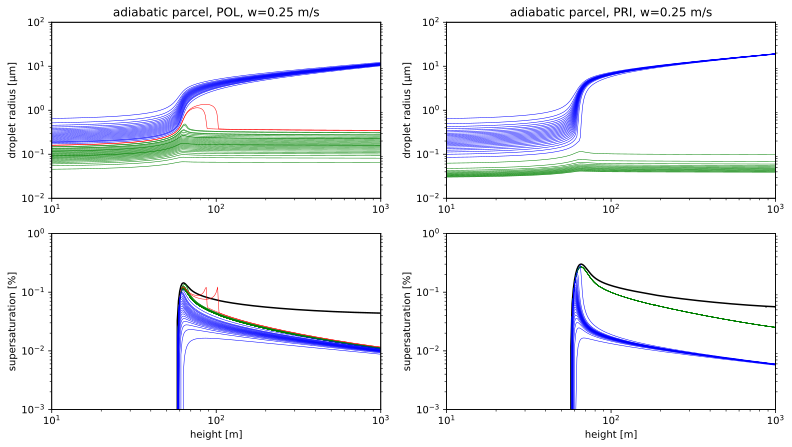

HTML(value="<a href='./supersaturation.pdf' target='_blank'>./supersaturation.pdf</a><br>")

In [26]:
fig, axs = pyplot.subplots(2, 2, sharey=False, figsize=(13, 7))

axS1 = axs[1,0]
axS1.plot(output_POL['products']['z'],np.asarray(output_POL['products']['S_max'])-100, color='black')
axS1.set_xlabel('height [m]')
axS1.set_ylabel('supersaturation [%]')
for drop_id, S_eq in enumerate(output_POL['attributes']['equilibrium supersaturation']):
    volume=output_POL['attributes']['volume'][drop_id]
    crit_volume=output_POL['attributes']['critical volume'][drop_id]
    if settings.formulae.trivia.radius(volume=np.asarray(volume)[10])>0.03*si.um:
        if np.all(np.asarray(volume)<np.asarray(crit_volume)):
            axS1.plot(
                output_POL['products']['z'],
                (np.asarray(S_eq)-1)*100,           #to jest saturacja ale nazywa się supersaturacja
                linewidth=0.5,
                color='green')
        elif np.asarray(volume)[-1]<np.asarray(crit_volume)[-1]:
            axS1.plot(
                output_POL['products']['z'],
                (np.asarray(S_eq)-1)*100,
                linewidth=0.5,
                color='red')   
        else:
            axS1.plot(
                output_POL['products']['z'],
                (np.asarray(S_eq)-1)*100,
                linewidth=0.5,
                color='blue')              


axS2 = axs[1,1]
axS2.plot(output_PRI['products']['z'],np.asarray(output_PRI['products']['S_max'])-100, color='black')
axS2.set_xlabel('height [m]')
axS2.set_ylabel('supersaturation [%]')
for drop_id, S_eq in enumerate(output_PRI['attributes']['equilibrium supersaturation']):
    volume=output_PRI['attributes']['volume'][drop_id]
    crit_volume=output_PRI['attributes']['critical volume'][drop_id]
    if settings.formulae.trivia.radius(volume=np.asarray(volume)[10])>0.03*si.um:
        if np.all(np.asarray(volume)<np.asarray(crit_volume)):
            axS2.plot(
                output_PRI['products']['z'],
                (np.asarray(S_eq)-1)*100,
                linewidth=0.5,
                color='green')
        elif np.asarray(volume)[-1]<np.asarray(crit_volume)[-1]:
            axS2.plot(
                output_PRI['products']['z'],
                (np.asarray(S_eq)-1)*100,
                linewidth=0.5,
                color='red')   
        else:
            axS2.plot(
                output_PRI['products']['z'],
                (np.asarray(S_eq)-1)*100,
                linewidth=0.5,
                color='blue')  
        

axR1 = axs[0,0]
for drop_id, volume in enumerate(output_POL['attributes']['volume']):
    if settings.formulae.trivia.radius(volume=np.asarray(volume))[10]>0.03*si.um:
        crit_volume=output_POL['attributes']['critical volume'][drop_id]
        if np.all(np.asarray(volume)<np.asarray(crit_volume)):
            axR1.plot(
                output_POL['products']['z'],
                settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                linewidth=0.5,
                color='green'
            )
        elif np.asarray(volume)[-1]<np.asarray(crit_volume)[-1]:
            axR1.plot(
                output_POL['products']['z'],
                settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                linewidth=0.5,
                color='red'
            )       
        else:
            axR1.plot(
                output_POL['products']['z'],
                settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                linewidth=0.5,
                color='blue'
            )
axR1.set_ylabel('droplet radius [μm]')
axR1.set_title('adiabatic parcel, POL, w=0.25 m/s')

axR2 = axs[0,1]
for drop_id, volume in enumerate(output_PRI['attributes']['volume']):
    if settings.formulae.trivia.radius(volume=np.asarray(volume))[10]>0.03*si.um:
        crit_volume=output_PRI['attributes']['critical volume'][drop_id]
        if np.all(np.asarray(volume)<np.asarray(crit_volume)):
            axR2.plot(
                output_PRI['products']['z'],
                settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                linewidth=0.5,
                color='green'
            )
        elif np.asarray(volume)[-1]<np.asarray(crit_volume)[-1]:
            axR2.plot(
                output_PRI['products']['z'],
                settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                linewidth=0.5,
                color='red'
            )     
        else:
            axR2.plot(
                output_PRI['products']['z'],
                settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                linewidth=0.5,
                color='blue'
            )
axR2.set_ylabel('droplet radius [μm]')
axR2.set_title('adiabatic parcel, PRI, w=0.25 m/s')

axS1_ = axS1.twinx() 
axS2_ = axS2.twinx() 
axR1_ = axR1.twinx() 
axR2_ = axR2.twinx() 
for ax in [axS1,axS1_,axS2,axS2_]:
    ax.set_ylim(0.001, 1)
    ax.set_xlim(10, 1000)
    ax.set_xscale('log')
    ax.set_yscale('log')
for ax in [axR1,axR1_,axR2,axR2_]:
    ax.set_xlim(10, 1000)
    ax.set_ylim(0.01, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
for ax in [axS1_,axS2_,axR1_,axR2_]:
    ax.yaxis.set_major_locator(ticker.NullLocator())
show_plot("supersaturation.pdf")

In [7]:
np.array(output_PRI['attributes']['critical volume']).shape

(50, 1002)

In [6]:
print(output_PRI['attributes'].keys())

dict_keys(['volume', 'dry volume', 'critical supersaturation', 'equilibrium supersaturation', 'critical volume'])
